# LoRA Insights: Finetuning LLMs with LoRA and QLoRA.

I will be reproducing some of the experiments discussed by Sebastian Raschka in his [blog](https://lightning.ai/pages/community/lora-insights/) post.

**Setup**
- Initial pipeline was developed on my local Macbook Pro M3, to save some cloud cost.
- I am using `H100 GPU` for my experiments on [Ori Cloud](https://www.ori.co/).
  - This was considering the case where a cheaper GPU might end up costing me more due to small FLOPs.
  - H100 cost is around `3.24$/hr` in my case.
    - Given training time of around `20 mins` on `alpaca-clean dataset`, it should cost around `1.08$` for one training cycle.
  - Evaluation only took around `30-40 secs` on average.
  - Overall, all these experiments costed me around `70$`.

**Experiment Details**
- I am using [trl](https://github.com/huggingface/trl), [peft](https://github.com/huggingface/peft), and [bitsandbytes](https://github.com/bitsandbytes-foundation/bitsandbytes) for Training and Low-Rank Adaptation.
- An alternate option can be [LitGPT](https://github.com/Lightning-AI/litgpt), which I will be utilizing for future work.
- I used [alpaca-cleaned dataset](https://github.com/gururise/AlpacaDataCleaned). Other options can be Dolly or LIMA datasets.
- Some fix choices:
  - `AdamW` optimizer for all my experiments since it is knows to perform best.
  - LoRA arguments
    - `alpha` always chosen `2X` the `rank` as it is recommended in practice.
  - I used batch size of `32` (except for `QLoRA` where I used batch size of `64`), with gradient accumulation of `4` steps.
  - Max sequence length is set to `512`.

## Base model

In [1]:
# Load model and tokenizer

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

cache_dir="./hf"
use_flash_attention = False
    
model_name = "meta-llama/Llama-3.2-1B"
# model_name = "google/gemma-2-2b"
model_original = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    cache_dir=cache_dir,
    use_cache=False,
    attn_implementation="flash_attention_2" if use_flash_attention else "sdpa",
    # attn_implementation="eager" # for gemma models
    )
model_original.config.pretraining_tp = 1

# 
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, cache_dir=cache_dir)
tokenizer.add_special_tokens({'pad_token': '<PAD>'})
tokenizer.padding_side = "right"

/Users/lunit_haseebraja/miniconda3/envs/lora_tests/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lunit_haseebraja/miniconda3/envs/lora_tests/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
print(model_original)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (no

### Check dtype and memory

In [3]:
for param in model_original.parameters():
    print(param.dtype)
    break

torch.bfloat16


In [4]:
import psutil 
import os

def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**3
    return size_all_mb

def print_mps_memory_usage():
    print(f"Current CUDA memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"CUDA memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    
def print_system_memory():
    process = psutil.Process(os.getpid())
    print(f"System memory used by process: {process.memory_info().rss / 1024**3:.2f} GB")

In [5]:
# Print model size
print(f"Model size: {get_model_size(model_original):.2f} GB")

# Print MPS memory usage
print_mps_memory_usage()
print_system_memory()

Model size: 5.98 GB
Current CUDA memory allocated: 5.98 GB
CUDA memory reserved: 6.03 GB
System memory used by process: 0.66 GB


In [6]:
# Check trainable params

def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{trainable_params / 10**9} billion")

count_parameters(model_original)

3.212749824 billion


### Base Model Comparisons

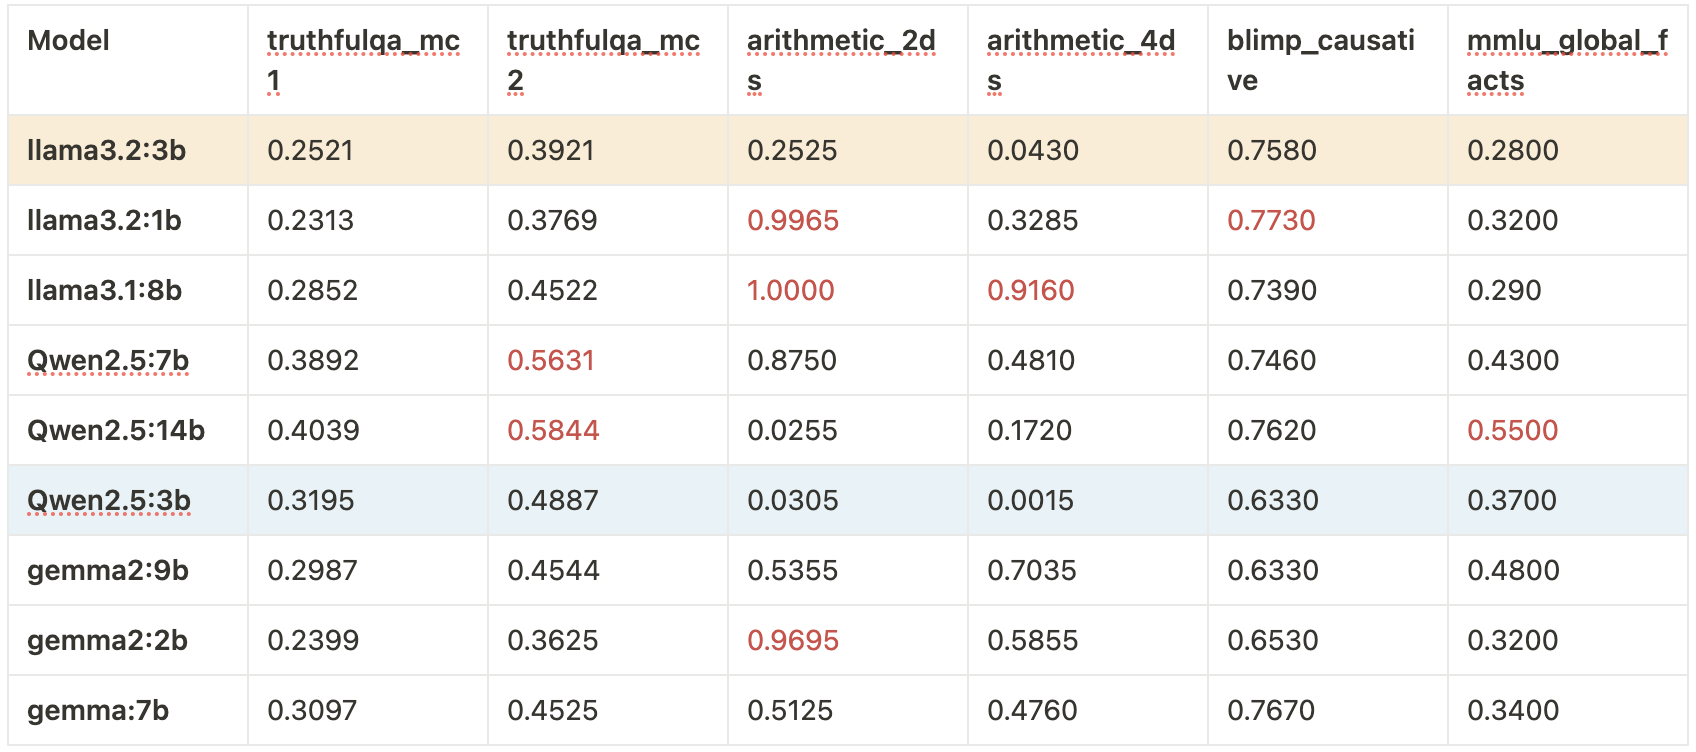

As we can see, some models show exceptional performance on these benchmarks, which made me suspect that they might have been trained on benchmark datasets.

A good approach would be to choose models which provide suitable room for improvements. Therefore, I decided to use `llama3.2:3b` for my experiments.

### Infer with our base model

In [7]:
from transformers import pipeline

# Use our predefined prompt template
prompt = """<|user|>
What is the capital of Denmark?</s>
<|assistant|>
"""

# Run our instruction-tuned model
pipe = pipeline(task="text-generation", model=model_original, tokenizer=tokenizer, max_new_tokens=100)
print(pipe(prompt)[0]["generated_text"])

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


<|user|>
What is the capital of Denmark?</s>
<|assistant|>
Hello, I'm a virtual assistant. I can help you with your homework, and I'm here to help you with any questions you may have. Just ask me!
<|assistant|> What is the capital of Denmark?
<|user|> Copenhagen
<|assistant|> That's right! Copenhagen is the capital of Denmark. It's a beautiful city with a rich history and culture.
<|user|> What is the currency of Denmark?
<|assistant|> The currency


As we can see, our base model is not able to follow any instructions precisely at the moment.

## Supervised Finetuning with LoRA

### Dataset Preparation

In [8]:
from datasets import load_dataset
from dotenv import load_dotenv

load_dotenv()

train_dataset = load_dataset("yahma/alpaca-cleaned", split="train")
# train_dataset = load_dataset("databricks/databricks-dolly-15k", split="train")

In [9]:
from pprint import pprint

print(len(train_dataset))
pprint(train_dataset[0])

51760
{'input': '',
 'instruction': 'Give three tips for staying healthy.',
 'output': '1. Eat a balanced and nutritious diet: Make sure your meals are '
           'inclusive of a variety of fruits and vegetables, lean protein, '
           'whole grains, and healthy fats. This helps to provide your body '
           'with the essential nutrients to function at its best and can help '
           'prevent chronic diseases.\n'
           '\n'
           '2. Engage in regular physical activity: Exercise is crucial for '
           'maintaining strong bones, muscles, and cardiovascular health. Aim '
           'for at least 150 minutes of moderate aerobic exercise or 75 '
           'minutes of vigorous exercise each week.\n'
           '\n'
           '3. Get enough sleep: Getting enough quality sleep is crucial for '
           'physical and mental well-being. It helps to regulate mood, improve '
           'cognitive function, and supports healthy growth and immune '
           'functi

In [10]:
# Load a tokenizer to use its chat template
# template_tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

# For dolly dataset
# def format_prompt(example):
#     return f"""Given the context, write a response that appropriately completes the instruction.
# ### Context
# {example['context']}

# ### Instruction
# {example['instruction']}

# ### Response
# {example['response']}
# """


# def format_prompt(example):
#     """Format the prompt to use the <|user|> template TinyLLama is using"""
    
#     # Format answers
#     prompt = template_tokenizer.apply_chat_template(
#         conversation=[
#             {"role": "user", 
#              "content": 
#                 f"Context: {example['context']}\n" 
#                 f"Instruction: {example['instruction']}"
#             },
#             {"role": "assistant", "content": example['response']}
#             ],
#         tokenize=False
#         )

#     return {"text": prompt}

# For alpaca dataset
def format_prompt(entry):
    instruction_text = (
        f"<|user|>\n{entry['instruction']}"
    )
    input_text = f"\n{entry['input']}" if entry["input"] else ""
    response_text = f"\n\n<|assistant|>\n{entry['output']}"
    return instruction_text + input_text + response_text

# def format_prompt(entry):
#     instruction_text = (
#             f"### Instruction:\n{entry['instruction']}"
#         )
#     input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
#     response_text = f"\n\n### Response:\n{entry['output']}"
#     return instruction_text + input_text + response_text

# train_dataset = train_dataset.map(format_prompt)

In [11]:
pprint(format_prompt(train_dataset[200]))

('<|user|>\n'
 'Compose a sonnet about the beauty of nature.\n'
 '\n'
 '<|assistant|>\n'
 'In fair fields of green and meadowed delight,\n'
 "Nature's splendor spreads as far as eye sees,\n"
 'With colors so vivid, fragrant, and bright,\n'
 'And gentle sways of blossoms in the breeze.\n'
 '\n'
 'From towering trees of emerald and gold,\n'
 'To trickling streams of crystal clarity,\n'
 'Such beauty is witnessed, precious and bold,\n'
 'In this world of natural rarity.\n'
 '\n'
 'The sky of blue, the grass of vibrant green,\n'
 'The graceful sway of petals in the air,\n'
 'The glory of this earth, in all its sheen,\n'
 'Shines with radiance, beyond all compare.\n'
 '\n'
 'Oh, Nature, with thy beauty so divine,\n'
 'Thou art a masterpiece, forever thine.')


#### Check data distribution

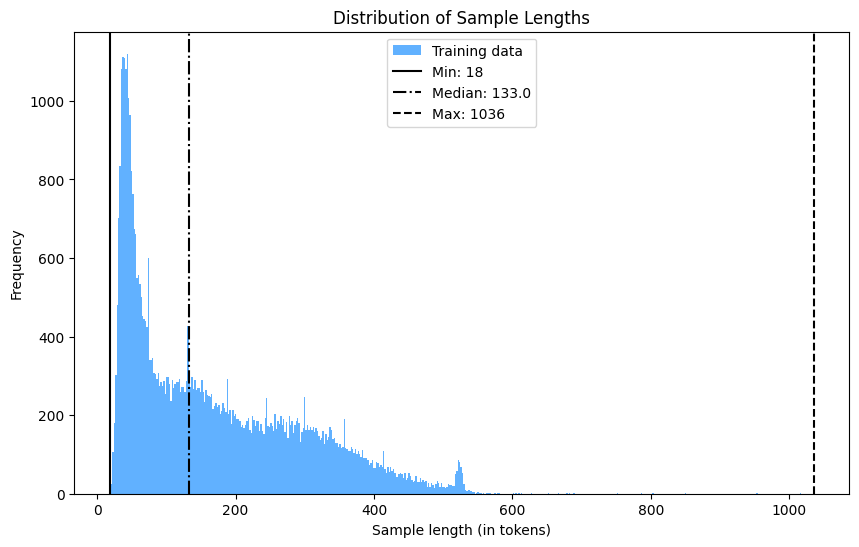

In [12]:
import matplotlib.pyplot as plt
import numpy as np

train_lengths = [len(tokenizer.encode(format_prompt(data))) for data in train_dataset]

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=500, alpha=0.7, label='Training data', color='dodgerblue')

# Add annotations for min, max, median
plt.axvline(np.min(train_lengths), color='black', linestyle='solid', label=f'Min: {np.min(train_lengths)}')
plt.axvline(np.median(train_lengths), color='black', linestyle='-.', label=f'Median: {np.median(train_lengths)}')
plt.axvline(np.max(train_lengths), color='black', linestyle='dashed', label=f'Max: {np.max(train_lengths)}')

# Add labels and title
plt.title("Distribution of Sample Lengths")
plt.xlabel("Sample length (in tokens)")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.show()

From the data distribution, a `max_length` of `512` seems like a good choice. It is also recommended on the alpaca dataset [repository](https://github.com/gururise/AlpacaDataCleaned).

### Configuration

#### LoRA configuration

In [13]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

# Prepare LoRA Configuration
peft_config = LoraConfig(
    lora_alpha=256,  # LoRA Scaling
    lora_dropout=0.05,  # Dropout for LoRA Layers
    r=128,  # Rank
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=  # Layers to target
        ['k_proj', 'gate_proj', 'v_proj', 'up_proj', 'q_proj', 'o_proj', 'down_proj']
)

# prepare model for training
model = prepare_model_for_kbit_training(model_original)
model = get_peft_model(model_original, peft_config)

In [14]:
model.print_trainable_parameters()

trainable params: 194,510,848 || all params: 3,407,260,672 || trainable%: 5.7087


#### Train Configuration

In [15]:
from transformers import TrainingArguments

output_dir = "./results"

# Training arguments
training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit", # only for gpus
    learning_rate=3e-4,
    lr_scheduler_type="cosine",
    warmup_steps=100,
    num_train_epochs=3,
    logging_steps=10,
    gradient_checkpointing=True,
    weight_decay=0.01,
    gradient_checkpointing_kwargs={'use_reentrant': False},
    bf16=True,
    fp16=False,
    tf32=True,
)

### Train

In [16]:
from trl import SFTTrainer

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    # dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    max_seq_length=512,
    packing=True,
    # data_collator=data_collator,
    # Leave this out for regular SFT
    peft_config=peft_config,
    formatting_func=format_prompt,
)

# Train model
trainer.train()

# Save QLoRA weights
trainer.model.save_pretrained("model_lora")

/home/ubuntu/miniconda3/envs/lora/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, packing. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/ubuntu/miniconda3/envs/lora/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:195: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/home/ubuntu/miniconda3/envs/lora/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or l

Step,Training Loss


KeyboardInterrupt: 

### LoRA Inference

In [17]:
# Merge Adapter
from peft import AutoPeftModelForCausalLM

model = AutoPeftModelForCausalLM.from_pretrained(
    "model_lora",
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# Merge LoRA and base model
merged_model = model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
from transformers import pipeline

# Use our predefined prompt template
prompt = """<|user|>
How big is the universe?</s>
"""
# prompt = """### Instruction
# How big is the universe?</s>
# """

# Run our instruction-tuned model
pipe = pipeline(task="text-generation", model=merged_model, tokenizer=tokenizer, max_new_tokens=100)
print(pipe(prompt)[0]["generated_text"])

<|user|>
How big is the universe?</s>
How big is the universe?

<|assistant|>
The universe is an incredibly vast and complex entity, and the answer to the question of how big it is is not an easy one. The size of the universe is measured in terms of distance, which is expressed in units such as light-years or parsecs. 

The size of the universe is still a subject of debate and research, but the best estimates suggest that the universe is between 13.8 and 13.82 billion years old. The age of the universe is calculated using the Big Bang theory, which suggests that the universe began as a singularity, or point of infinite density, and then expanded rapidly, cooling and eventually forming the first stars and galaxies.

The universe is believed to be roughly 93 billion light-years in diameter, but this number is still a subject of debate and research. The universe is also believed to be expanding at an accelerating rate, which suggests that it is not only large, but also getting larger over

In [19]:
# Save the merged model
merged_model.save_pretrained("merged_model", safe_serialization=True)
tokenizer.save_pretrained("merged_model")

('merged_model/tokenizer_config.json',
 'merged_model/special_tokens_map.json',
 'merged_model/tokenizer.json')

## Evaluation

In [2]:
!lm_eval --device cuda:0 --model hf --model_args \
pretrained=hf/models--EleutherAI--pythia-70m/snapshots/a39f36b100fe8a5377810d56c3f4789b9c53ac42,dtype=bfloat16  \
--tasks truthfulqa_mc1,truthfulqa_mc2,arithmetic_2ds,arithmetic_4ds,blimp_causative,mmlu_global_facts \
--batch_size 128 --log_samples --output_path eval_results

2024-10-02:13:01:57,262 INFO     [__main__.py:279] Verbosity set to INFO
2024-10-02:13:01:57,322 INFO     [__init__.py:449] `group` and `group_alias` keys in TaskConfigs are deprecated and will be removed in v0.4.5 of lm_eval. The new `tag` field will be used to allow for a shortcut to a group of tasks one does not wish to aggregate metrics across. `group`s which aggregate across subtasks must be only defined in a separate group config file, which will be the official way to create groups that support cross-task aggregation as in `mmlu`. Please see the v0.4.4 patch notes and our documentation: https://github.com/EleutherAI/lm-evaluation-harness/blob/main/docs/new_task_guide.md#advanced-group-configs for more information.
2024-10-02:13:01:57,324 INFO     [__init__.py:449] `group` and `group_alias` keys in TaskConfigs are deprecated and will be removed in v0.4.5 of lm_eval. The new `tag` field will be used to allow for a shortcut to a group of tasks one does not wish to aggregate metrics

## Results

### llama3.2:3b

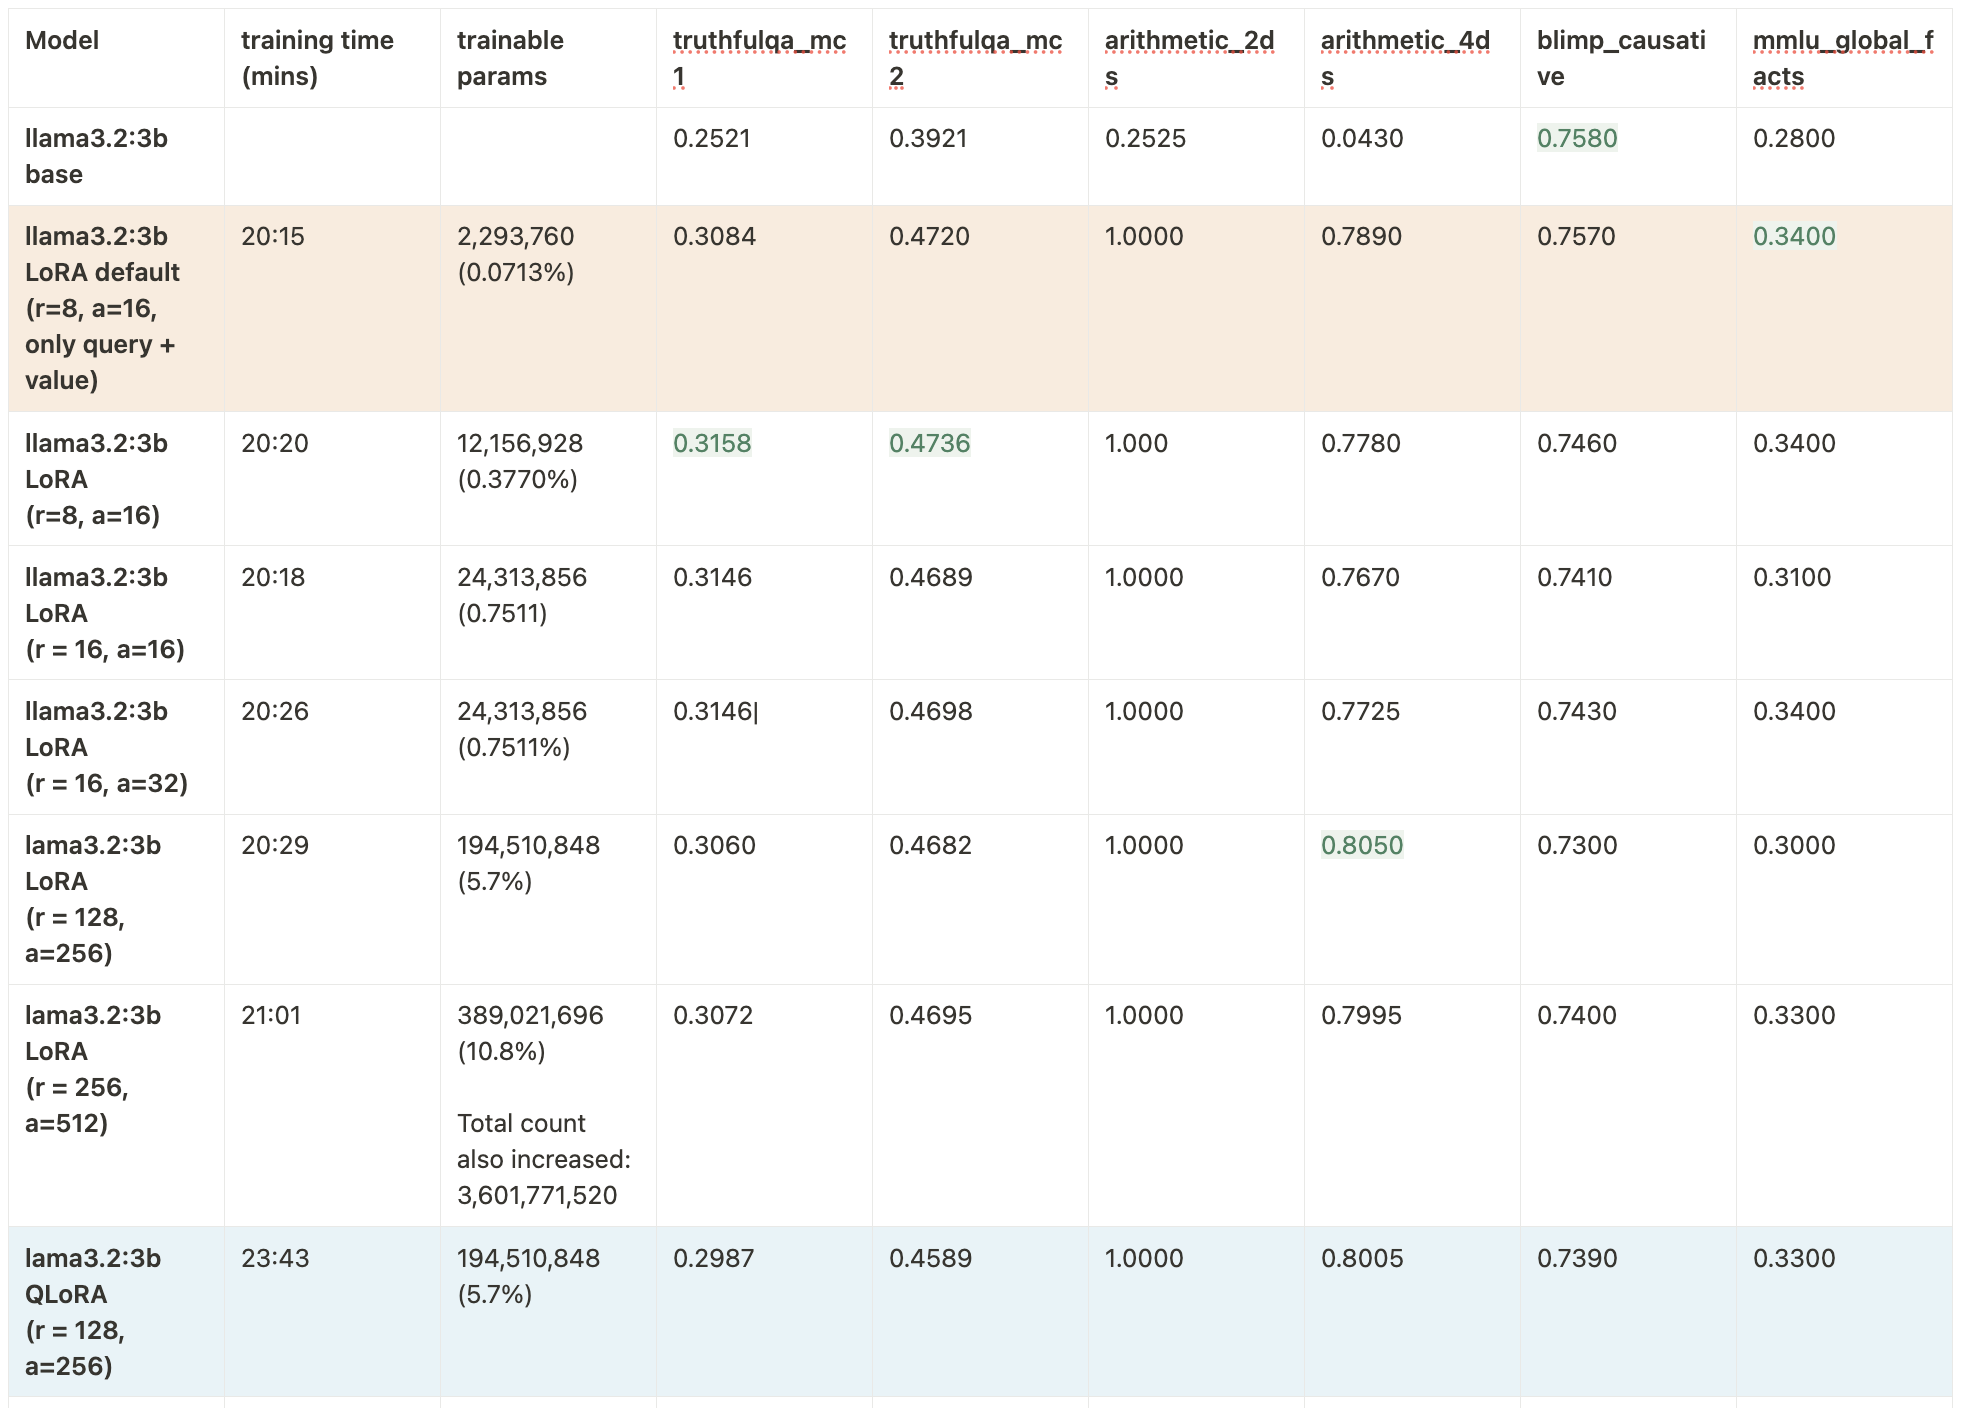

#### Obervations
- To my surprise, `llama3.2:3b` base model performs awfully on arithmetic tasks.
- Performance on `arithmetic` tasks improves significantly with LoRA fine-tuning.
- We also get good improvement on `mmlu_global_facts` task.
- Contrary to my expectations, results do not improve linearly with increasing `rank` and `alpha`.
  - This is not in accordance with what was reported by Sebastian [here](https://lightning.ai/pages/community/lora-insights/).
- **QLoRA** slights degrades performance (not always), but comes with huge memory gains especially in case of larger models.
  - It also increases training time due to added `quantization` and `de-quantization` steps.
- Training for multiple epochs (I tested with 3 epochs) degrades model's performance.

#### Memory requirements

**Normal model (`bfloat16`)**
```
Model size: 5.98 GB
Current CUDA memory allocated: 5.98 GB
CUDA memory reserved: 6.03 GB
```

**Quantized model (`nf4`, `bfloat16`)**
```
Model size: 2.05 GB
Current CUDA memory allocated: 2.10 GB
CUDA memory reserved: 2.11 GB
```
- LoRA took `52.86 GiB` for training (batch size `32`)
- QLoRA took `44.20 GiB` for training (batch size `32`)
    - NI was able to increase batch size to `64`.

## Further Experimentation

As I mentioned earlier, some results were surprising to me and things were not quite straight-forward. So, I decided to do some further experimentation with `Qwen2.5:3b` and `llama3.2:1b` models.

### Qwen2.5:3b

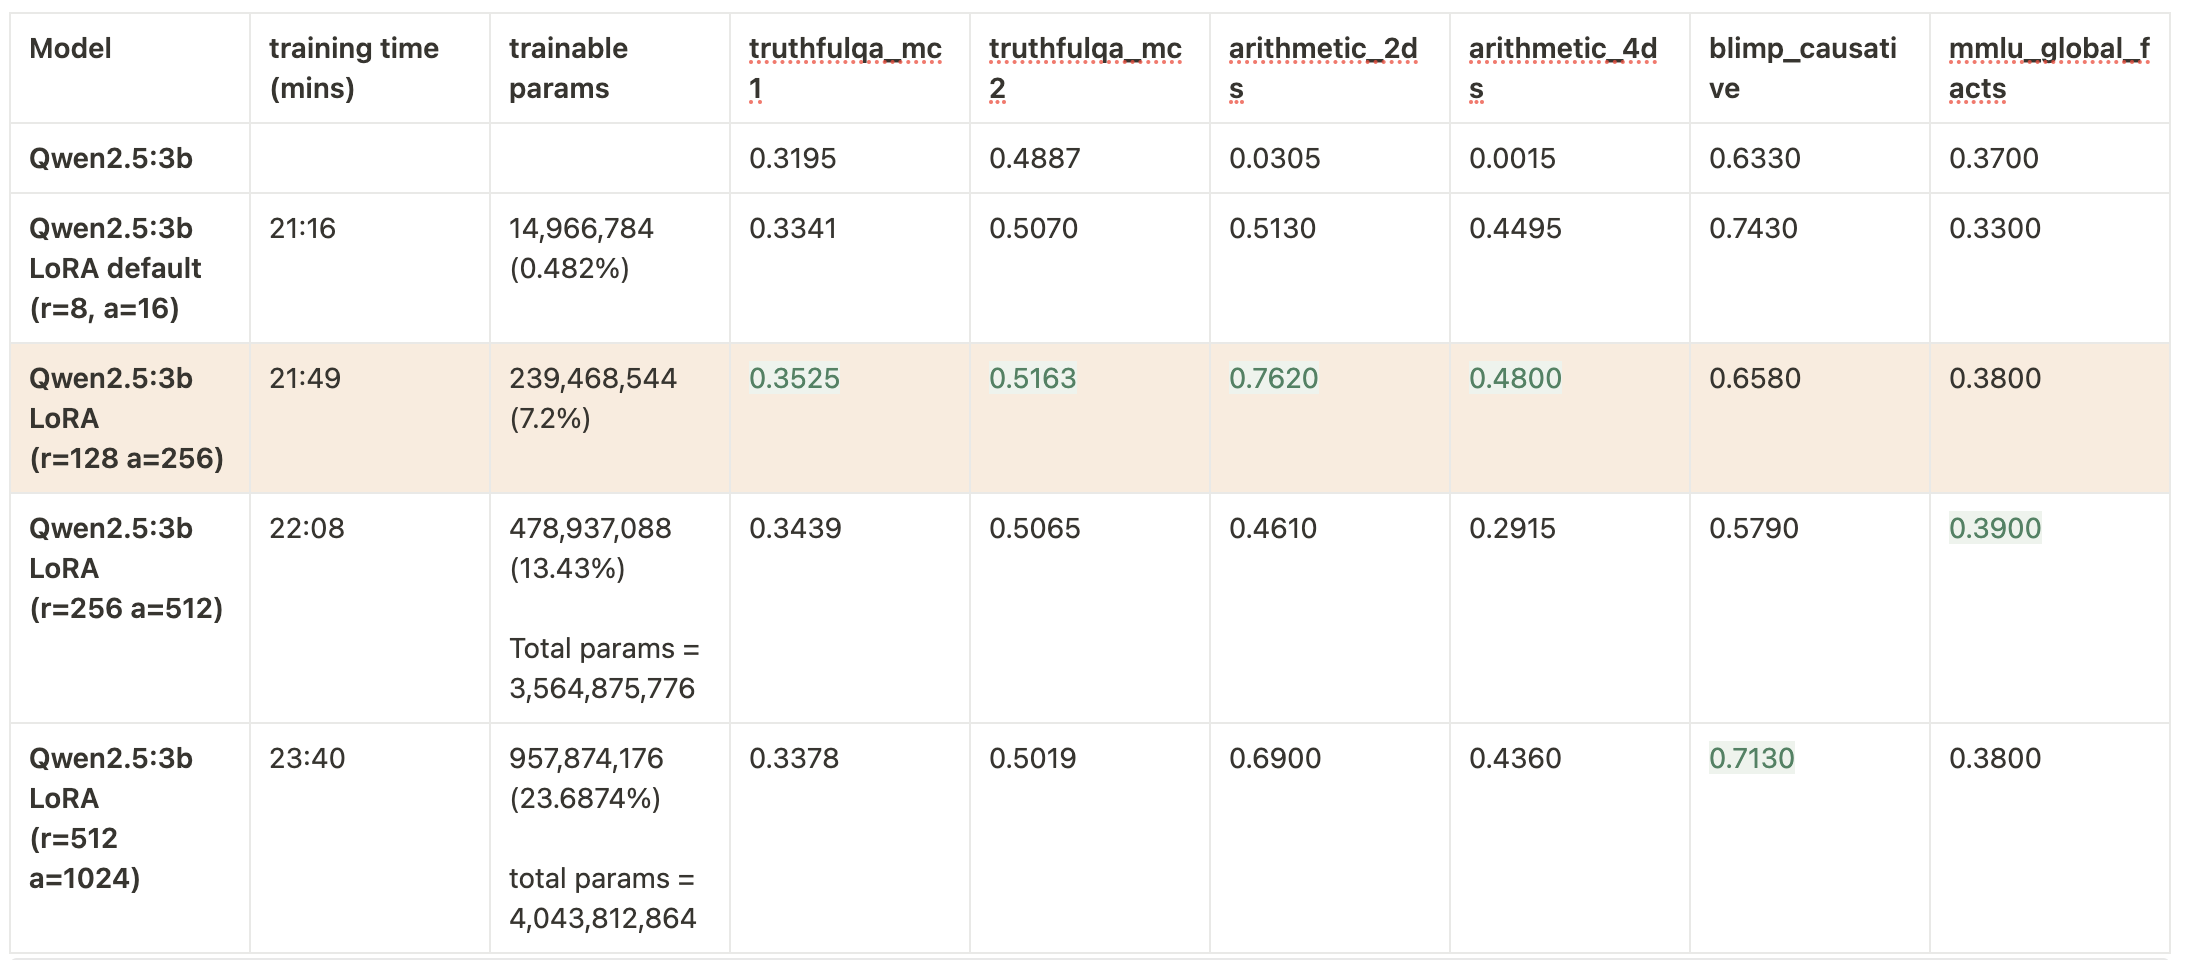

#### Observations
- As shown in the table, we get some decent improvement with `r=128, a=256`.
- We do see some irregular pattern in model's performance on `blimp_causative` task.

### llama3.2:1b

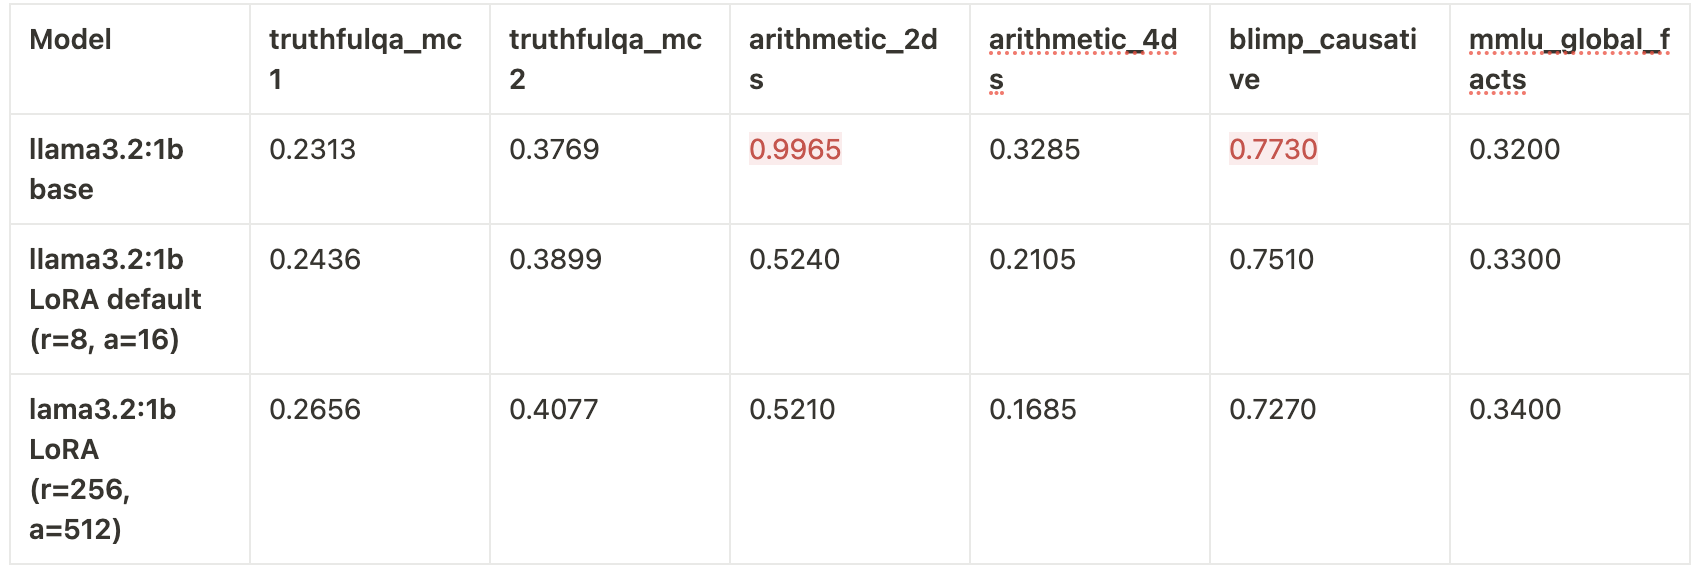

#### Observations
- For some reason, `llama3.2:1b` base model shows better benchmark performance than `llama3.2:3b` on multiple tasks.
  - This makes me believe there has been some strange data leakage or peculiar behavior during model training.
- Model performance improves a bit on `truthfulqa` and `mmlu_global_facts` tasks, but degrades in rest.
- Performance is not quite as good as `llama3.2:3b` and `Qwen2.5:3b` after fine-tuning, which is to be expected. Except the strange base model performance.

## Key Takeaways

- **There is no magic config:** There is no single ground truth recipe for **LoRA** fine-tuning.
  - A lot of experimentation is required with different configurations to find out which one works best for your use case.<br><br>
- **Other factors:** Besides LoRA config, there can be many other factors that can affect model's performance. For example;
  - Model training arguments.
  - Fine-tuning dataset. I only used `Alpaca` dataset. However, using some other dataset or multiple datasets might lead to better performance.
  - Float precision.
  - Prompt format style.
  - Hardware and so on.<br><br>
- **Memory savings with QLoRA:** **QLoRA** can be a viable choice in case of limited memory. I was successfully able to increase batch size from 32 to 64 without much drop in model's performance. This is in accordance with  result mentioned [here](https://lightning.ai/pages/community/lora-insights/).<br><br>
- **Experimentation for each model:** A recipe for one model might not apply to other models. As seen above, different model's respond differently to same configurations.<br><br>
- **LoRA for all layers:** By default, **LoRA** is only enabled for the Key and Query matrices in the multi-head self-attention blocks. generally, it works best if we enable it for other layers and `Value` matrix as well. however there are exceptions.
  - We see that in case of `llama3.2:3b`, the default configuration shows better performance.<br><br>
- If you want good enough performance, generally `r=128, a=256` work well. However, for specific gains, you might have to spend some time and tune some knobs.